INF6804<br>
Polytechnique Montréal<br>
TP3: Détection et suivi de multiples objets d'intérêt<br>

Auteurs:<br>
Marc-Olivier Bélanger - 1840713<br>
Pierre-Luc Chartier - 1805679

### Déclarations globales

In [33]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import os
import scipy.optimize as sci
import torchvision.models as models
import torchvision.transforms as transforms
import urllib.request as request

In [34]:
COCO_NAMES = ['background']
label_names = request.urlopen('https://raw.githubusercontent.com/gabilodeau/INF6804/master/utils/coco-labels.txt')
for label_name in label_names.readlines():
    COCO_NAMES.append(label_name.strip().decode('UTF-8'))

IOU_THRESHOLD = 0.5
SCORE_THRESHOLD = 0.95

source_path = "/Users/mabelal/Downloads/TP3_data/frames"

model = models.detection.maskrcnn_resnet50_fpn(pretrained=True).eval()

### Détection des objets (Mask R-CNN)

In [35]:
def detect_objects(img):
    preprocess = transforms.Compose([transforms.ToTensor()])
    tensors = [preprocess(img)]
    
    predictions = model(tensors)
    boxes = []
    
    for p in predictions:
        for j, score in enumerate(p['scores']):
            if score >= SCORE_THRESHOLD:
                label = p['labels'][j]
                is_cup_or_person = (COCO_NAMES[label] == "cup") #or (COCO_NAMES[label] == "person")

                if is_cup_or_person:
                    boxes.append(p['boxes'][j].detach().numpy())
    return boxes

### Description des objets (Histogramme de couleurs)

In [36]:
def calc_color_hist(img, bbox):
    roi = (bbox[0], bbox[1], bbox[2], bbox[3])
    mask = np.zeros((img.shape[0],img.shape[1]), np.uint8)
    cv2.rectangle(mask,(roi[0],roi[1]),(roi[2],roi[3]),255,-1,8,0);
    return cv2.calcHist([img],[0],mask,[64],[0,256])


def compare_color_hist(hist1, hist2):
    return cv2.compareHist(hist1, hist2, cv2.HISTCMP_BHATTACHARYYA)

### Association des données (Mean-Shift et algorithme hongrois)

In [37]:
def calc_cost_matrix(tracked_objects, prev_img, current_img, current_bboxes):
    cost_matrix = np.zeros((len(tracked_objects), len(current_bboxes)))
    tracked_objects_hists = []
    for i in range(0,len(tracked_objects)):
        hist_prev = calc_color_hist(prev_img, tracked_objects[i].box())
        tracked_objects_hists.append(hist_prev)
        for j in range(0,len(current_bboxes)):
            hist_current = calc_color_hist(current_img, current_bboxes[j])
            cost_matrix[i,j] = compare_color_hist(hist_prev, hist_current)
    return cost_matrix, tracked_objects_hists


def mean_shift(tracked_obj, hist, current_img):           
    retro = cv2.calcBackProject([current_img], [0], hist, [0,64], 1)

    end_crit = ( cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1 )
    
    to_box = tracked_obj.box()
    iterations, box = cv2.meanShift(retro, (to_box[0], to_box[1], to_box[2]-to_box[0], to_box[3]-to_box[1]), end_crit)
    x_min, y_min, width, height = box
    
    return x_min, y_min, x_min+width, y_min+height

        
def associate_data(tracked_objects, prev_img, current_img, current_bboxes):    
    cost_matrix, hists = calc_cost_matrix(tracked_objects, prev_img, current_img, current_bboxes)
    row_ind, col_ind = sci.linear_sum_assignment(cost_matrix)
    
    for i in range(0, len(row_ind)):
        # check if association from hungarian algorithm makes sense based on coordinates
        if tracked_objects[row_ind[i]].is_close_from(current_bboxes[col_ind[i]]):
            # model detected object, update it with its predicted bbox
            tracked_objects[row_ind[i]].was_detected = True
            x_min, y_min, x_max, y_max = current_bboxes[col_ind[i]]
            tracked_objects[row_ind[i]].update(x_min, y_min, x_max, y_max)
    
    # apply mean-shift to tracked objects that were not detected by the model
    for ob in tracked_objects.values():
        if not ob.was_detected:
            x_min, y_min, x_max, y_max = mean_shift(ob, hists[ob.object_id], current_img)
            ob.update(x_min, y_min, x_max, y_max)
        else:
            # reset for next frame
            ob.was_detected = False
            
            
    return row_ind, col_ind

### Algorithme principal

In [38]:
class TrackedObject:
    def __init__(self, object_id, x_min, y_min, x_max, y_max):
        self.object_id = object_id
        self.count = 0
        self.x_min = x_min
        self.x_max = x_max
        self.y_min = y_min
        self.y_max = y_max
        self.was_detected = False
    
    
    def update(self, x_min, y_min, x_max, y_max, count = None):
        self.x_min = x_min
        self.x_max = x_max
        self.y_min = y_min
        self.y_max = y_max
        
        if count is not None:
            self.count = count
            
    
    def box(self):
        return self.x_min, self.y_min, self.x_max, self.y_max
    
    
    def is_close_from(self, box):
        limit = 100
        if box[0] < self.x_min - limit or box[0] > self.x_max + limit:
            return False
        elif box[2] < self.x_min - limit or box[2] > self.x_max + limit:
            return False
        elif box[1] < self.y_min - limit or box[1] > self.y_max + limit:
            return False
        elif box[3] < self.y_min - limit or box[3] > self.y_max + limit:
            return False
        else:
            return True
        
    
    def __str__(self):
        ws = " "
        return ws.join([str(self.object_id+1), str(round(self.x_min)),
                        str(round(self.x_max)), str(round(self.y_min)), str(round(self.y_max))])

In [39]:
def algo(path_to_frames, tracked_objects, result_file):
    # some magic to get the frames in the right order
    frames = [name for name in os.listdir(path_to_frames) if os.path.isfile(os.path.join(path_to_frames, name))]
    frames = sorted(frames)
    frames = sorted(frames, key = lambda s : len(s))
    
    # initial frame
    prev_img = cv2.imread(os.path.join(path_to_frames, frames[0]), cv2.IMREAD_GRAYSCALE)
    f = open(result_file, "w+")
    for i in range(0, len(tracked_objects)):
        f.write("1 " + str(tracked_objects[i]) + "\n")
    
    # main loop
    for i in range(1, len(frames)):
        img = cv2.imread(os.path.join(path_to_frames, frames[i]), cv2.IMREAD_GRAYSCALE)
        boxes = detect_objects(img)
        associate_data(tracked_objects, prev_img, img, boxes)
        
        for j in range(0, len(tracked_objects)):
            f.write(str(i+1) + " " + str(tracked_objects[j]) + "\n")
        
        prev_img = img
        
        if (i % 5) == 0:
            print("Progress: " + frames[i])
    
    f.close()

In [40]:
def algo_mot():
    return None

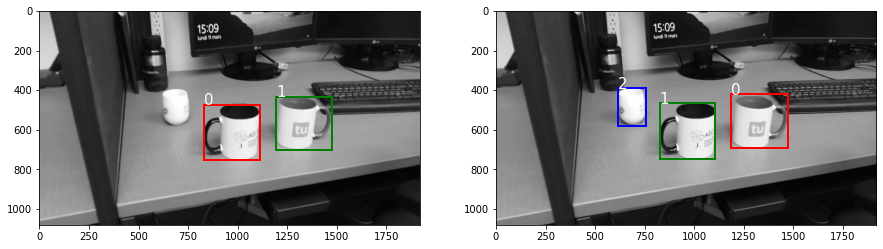

1 830 1112 474 755
2 1194 1479 433 700
[0 1]
[1 0]
1 826 1105 466 746
2 1185 1472 421 694


In [41]:
### Test association des données ###
img = cv2.imread(os.path.join(source_path, "frame1.jpg"), cv2.IMREAD_GRAYSCALE)

img2 = cv2.imread(os.path.join(source_path, "frame2.jpg"), cv2.IMREAD_GRAYSCALE)
b2 = detect_objects(img2)

fig, axarr = plt.subplots(1, 2, figsize=(15,15))
bboxcolor = 'rgbcmy'

axarr[0].imshow(img, cmap = plt.cm.gray)
for i in range(0, len(tracked_objects)):
    b = tracked_objects[i].box()
    rect = patches.Rectangle((b[0],b[1]),b[2]-b[0],b[3]-b[1],linewidth=2, edgecolor = bboxcolor[i], facecolor='none')
    axarr[0].add_patch(rect)
    axarr[0].text(b[0], b[1], i, color='white', fontsize=15)

axarr[1].imshow(img2, cmap = plt.cm.gray)
for i, b in enumerate(b2):
    rect = patches.Rectangle((b[0],b[1]),b[2]-b[0],b[3]-b[1],linewidth=2, edgecolor = bboxcolor[i], facecolor='none')
    axarr[1].add_patch(rect)
    rect = patches.Rectangle((b[0], b[1]), b[2]-b[0], b[3]-b[1], linewidth=2, edgecolor=bboxcolor[i], facecolor='none')
    axarr[1].add_patch(rect)
    axarr[1].text(b[0], b[1], i, color='white', fontsize=15)
    
plt.show()

for to in tracked_objects.values():
    print(to)

row_ind, col_ind = associate_data(tracked_objects, img, img2, b2)
print(row_ind)
print(col_ind)

for to in tracked_objects.values():
    print(to)

############

### MOT17-11: Forward moving camera in a busy shopping mall

In [42]:
# calcul du MOTA en utilisant IoU > 50%

# will need to create tracked_objects or smtg
# call algo, print in results file, then use the file to compute MOTA

### MOT17-05: Street scene from a moving platform

In [43]:
# calcul du MOTA en utilisant IoU > 50%

### MOT17-13 : Filmed from a bus on a busy intersection

In [44]:
# calcul du MOTA en utilisant IoU > 50%

### Résultats sur les trames fournies

In [45]:
# init.txt
cup_1 = TrackedObject(0, 830, 474, 1112, 755)
cup_2 = TrackedObject(1, 1194, 433, 1479, 700)

tracked_objects = {
    cup_1.object_id : cup_1,
    cup_2.object_id : cup_2
}


algo("/Users/mabelal/Downloads/TP3_data/frames", tracked_objects, "result_cups.txt")

Progress: frame6.jpg
Progress: frame11.jpg
Progress: frame16.jpg
Progress: frame21.jpg
Progress: frame26.jpg
Progress: frame31.jpg
Progress: frame36.jpg
Progress: frame41.jpg
Progress: frame46.jpg
Progress: frame51.jpg
Progress: frame56.jpg
Progress: frame61.jpg
Progress: frame66.jpg
Progress: frame71.jpg
Progress: frame76.jpg
Progress: frame81.jpg
Progress: frame86.jpg
Progress: frame91.jpg
Progress: frame96.jpg
Progress: frame101.jpg
Progress: frame106.jpg
Progress: frame111.jpg
Progress: frame116.jpg
Progress: frame121.jpg
Progress: frame126.jpg
Progress: frame131.jpg
Progress: frame136.jpg
Progress: frame141.jpg
Progress: frame146.jpg
Progress: frame151.jpg
Progress: frame156.jpg
Progress: frame161.jpg
Progress: frame166.jpg
Progress: frame171.jpg
Progress: frame176.jpg
Progress: frame181.jpg
Progress: frame186.jpg
Progress: frame191.jpg
Progress: frame196.jpg
Progress: frame201.jpg
Progress: frame206.jpg
Progress: frame211.jpg
Progress: frame216.jpg
Progress: frame221.jpg
Progress

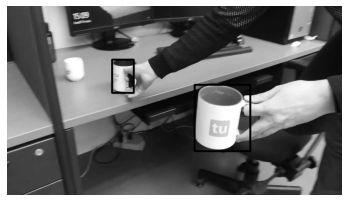

frame148.jpg
148 1 602 726 306 496

148 2 1075 1394 450 829



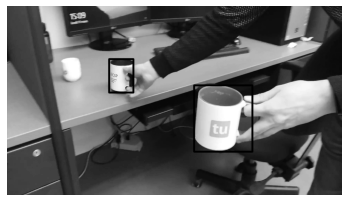

frame149.jpg
149 1 585 724 303 494

149 2 1072 1406 453 832



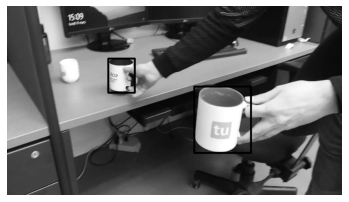

frame150.jpg
150 1 580 732 300 495

150 2 1073 1398 460 839



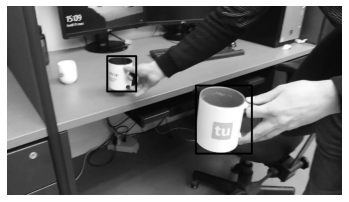

frame151.jpg
151 1 574 740 286 488

151 2 1082 1403 454 843



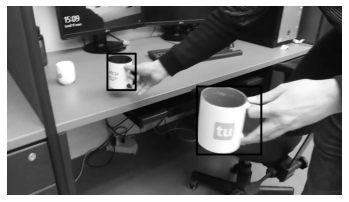

frame152.jpg
152 1 575 737 272 480

152 2 1088 1457 459 848



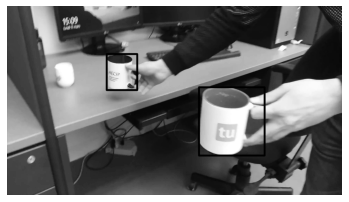

frame153.jpg
153 1 571 746 274 480

153 2 1100 1476 464 854



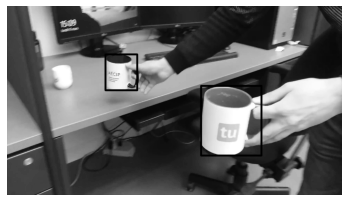

frame154.jpg
154 1 564 746 276 481

154 2 1112 1458 456 854



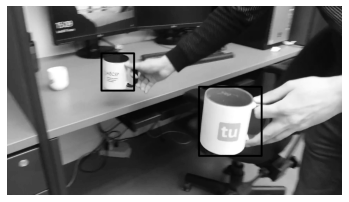

frame155.jpg
155 1 541 728 270 483

155 2 1100 1459 461 856



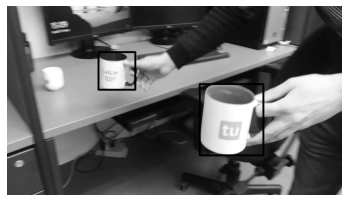

frame156.jpg
156 1 524 735 263 478

156 2 1104 1469 446 853



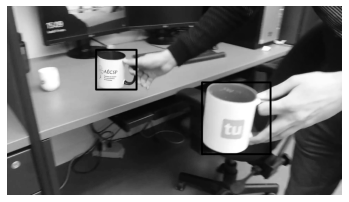

frame157.jpg
157 1 510 742 250 477

157 2 1117 1510 436 846



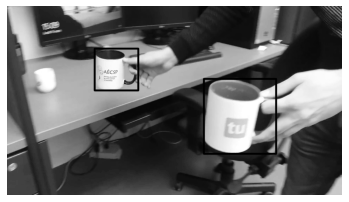

frame158.jpg
158 1 502 752 243 482

158 2 1128 1542 416 844



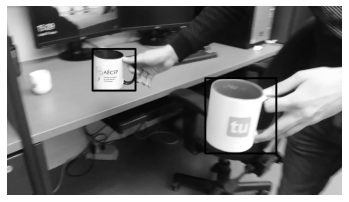

frame159.jpg
159 1 490 736 245 483

159 2 1136 1543 412 842



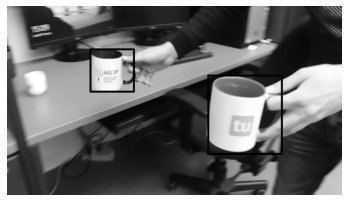

frame160.jpg
160 1 478 727 247 489

160 2 1153 1575 397 845



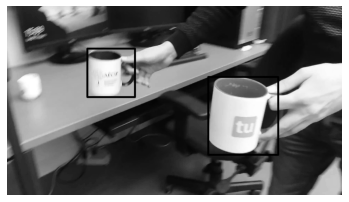

frame161.jpg
161 1 460 733 243 520

161 2 1153 1554 405 850



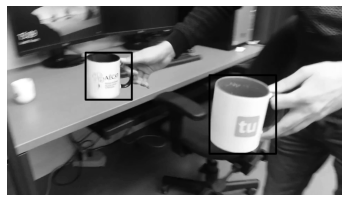

frame162.jpg
162 1 450 715 266 535

162 2 1160 1542 395 844



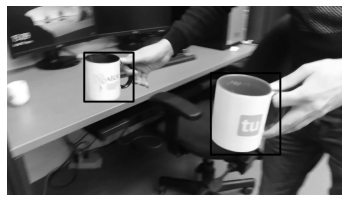

frame163.jpg
163 1 442 725 266 546

163 2 1168 1566 383 849



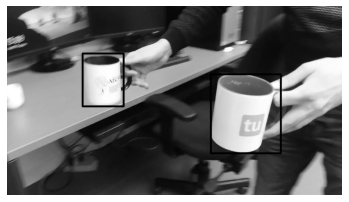

frame164.jpg
164 1 433 668 271 573

164 2 1168 1569 390 841



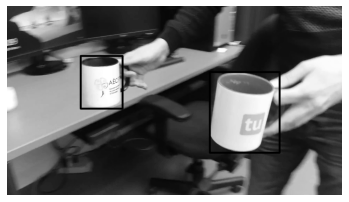

frame165.jpg
165 1 422 662 285 586

165 2 1162 1562 377 838



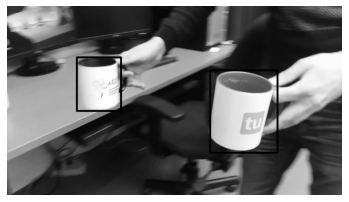

frame166.jpg
166 1 400 653 293 599

166 2 1164 1550 367 838



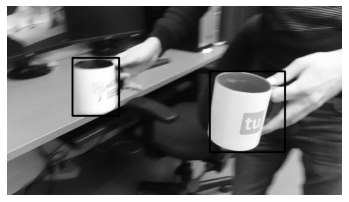

frame167.jpg
167 1 375 642 296 627

167 2 1162 1593 373 835



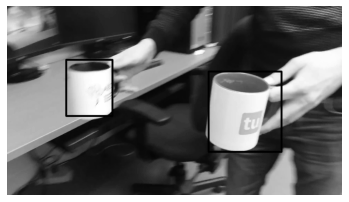

frame168.jpg
168 1 339 604 307 628

168 2 1155 1573 374 833



IndexError: list index out of range

In [28]:
### Validation des résultats

f = open("result_cups.txt", "r")
lines = f.readlines()
f.close()

frames = [name for name in os.listdir(source_path) if os.path.isfile(os.path.join(source_path, name))]
frames = sorted(frames)
frames = sorted(frames, key = lambda s : len(s))

i = 1
for j in range (0, 50):
    img = cv2.imread(os.path.join(source_path, frames[i-1+j]), cv2.IMREAD_GRAYSCALE)
    
    x_min, x_max, y_min, y_max = lines[(2*(i-1+j))].split(" ")[-4:]
    img = cv2.rectangle(img, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (0,0,0), 10)
    
    x_min, x_max, y_min, y_max = lines[(2*(i-1+j))+1].split(" ")[-4:]
    img = cv2.rectangle(img, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (0,0,0), 10)
    
    plt.imshow(img, cmap=plt.cm.gray)
    plt.axis("off")
    plt.show()
    
    print(frames[i-1+j])
    print(lines[(2*(i-1+j))])
    print(lines[(2*(i-1+j))+1])
